# Options Straddle Stock Price Predictor

### This library and script allows the user to see the current real time market price of a straddle position. Using this information this script provides the user with a visualization of the predicted price movement for a given stock. It also provides the user with the exact percentage move being priced into the options chain in real time.

In [1]:
### LIBRARIES AND PACKAGES

# BASIC DATA HANDLING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import datetime as dt
import time
from dateutil.parser import parse


# FINANCE LIBRARIES
import yahoo_fin.stock_info as si
from yahoo_fin.options import *
from yahoo_fin import news
import yfinance as yf
import opstrat as op


# OPTIONS AND SETTINGS
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
def get_straddle_predcition(ticker):

    ### GET EXPIRATION DATES AND OPTIONS CHAIN DATA
    # Grabs options expiration dates
    expiration_dates = get_expiration_dates(ticker)
    chain = get_options_chain(ticker, expiration_dates[2])
    
    # Stores Call and Put chains in Dataframes
    calls_df = pd.DataFrame(chain['calls'])
    puts_df = pd.DataFrame(chain['puts'])
    
    # Rounding function for underlying price and strike price
    def round_by5(x, base=5):
        high = base * np.round(x/base)
        low = base * np.round(x/base) - base
        return int(low), int(high)
    
    
    ### GET CURRENT PRICE OF UNDERLYING
    underlying = yf.Ticker(ticker)
    lastclose = pd.Series(underlying.history(period='1d')['Close'])
    price = lastclose.values
    rounded_price = round(price[0], 2)
    
    ### DISPLAY AT THE MONEY OPTIONS
    # ATM call
    high_strike = (calls_df.where(calls_df['Strike'] == round_by5(price)[1]))
    atm_call = (high_strike.dropna())
    
    # ATM put
    high_strike = (puts_df.where(puts_df['Strike'] == round_by5(price)[1]))
    atm_put = (high_strike.dropna())
    
    ### VISUALIZE STRADDLE
    # Format Date
    parsed_date = parse(expiration_dates[2])
    parsed_date_str = str(parsed_date).strip(' 00:00:00')
    
    # Plot Straddle
    op_1={'op_type': 'c', 'strike':round_by5(price)[1], 'tr_type': 'b'}
    op_2={'op_type': 'p', 'strike':round_by5(price)[1], 'tr_type': 'b'}
    
    op.yf_plotter(ticker=ticker, exp=parsed_date_str, op_list=[op_1, op_2])
    
    ### CALCULATE ANTICIAPTED MOVE
    # Straddle Cost
    call_price = atm_call['Last Price']
    put_price = atm_put['Last Price']
    straddle_float = call_price + call_price
    straddle_cost = straddle_float.to_numpy()[0] * 100
    
    # Calculate anticipated move
    block_share_cost = price * 100
    anticipated_move = (straddle_cost / block_share_cost)
    
    #format_anticiapted_move = anticipated_move.astype(float).tolist()
    pct_anticipated_move = (anticipated_move * 100)
    pct_move = np.round(pct_anticipated_move[0], 2)
    
    # Upper and Lower price boundaries
    upper = (price*anticipated_move + price)
    upper_price = round(upper[0], 2)
    
    lower = (price - (price*anticipated_move))
    lower_price = round(lower[0], 2)
    
    
    
    
    print()
    print(ticker, 'current price:', rounded_price)
    print('Total cost of entering into an ATM straddle position: $', round(straddle_cost, 2))
    print('Anticipated move for', ticker, 'stock by:', parsed_date_str, 'is approximately:', pct_move,'%')
    print('According to this prediction, the price is predicted to stay between: $',lower_price,'and: $', upper_price)


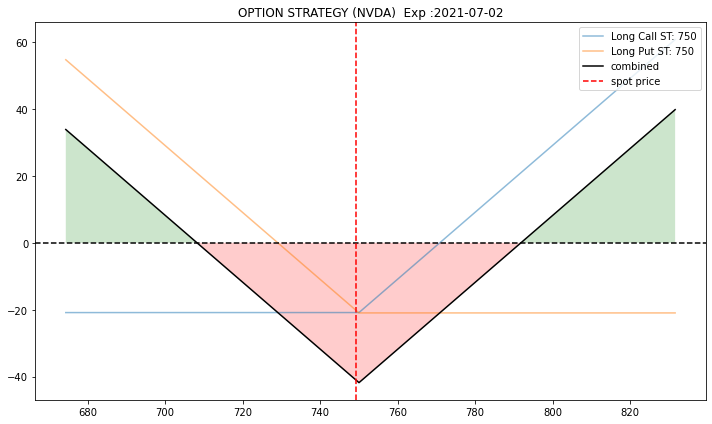


NVDA current price: 748.06
Total cost of entering into an ATM straddle position: $ 4170.0
Anticipated move for NVDA stock by: 2021-07-02 is approximately: 5.57 %
According to this prediction, the price is predicted to stay between: $ 706.36 and: $ 789.76


In [3]:
get_straddle_predcition('NVDA')